In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt

## 1. activation functions

In [2]:
# define the sigmoid function
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

Text(0.5, 1.0, 'Sigmoid')

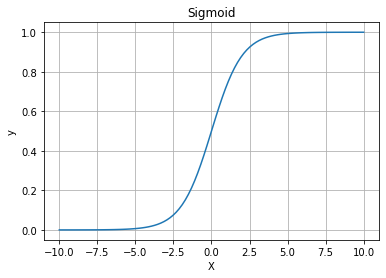

In [3]:
x = np.linspace(-10, 10, 100)
y = sigmoid(x)

plt.plot(x, y)
plt.grid("on")
plt.xlabel("X")
plt.ylabel("y")
plt.title("Sigmoid")

In [4]:
# define the ReLU activation
def relu(x):
    return np.maximum(x, 0)

Text(0.5, 1.0, 'ReLU')

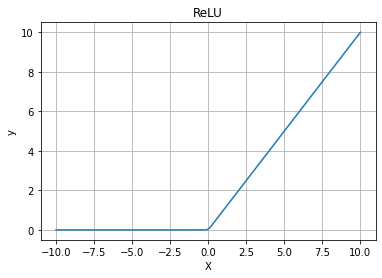

In [5]:
x = np.linspace(-10, 10, 100)
y = relu(x)

plt.plot(x, y)
plt.grid("on")
plt.xlabel("X")
plt.ylabel("y")
plt.title("ReLU")

In [6]:
# define the Tanh activation
def tanh(x):
    return 2 / (1 + np.exp(- 2 * x)) - 1

Text(0.5, 1.0, 'Tanh')

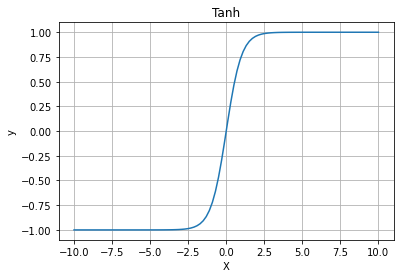

In [7]:
x = np.linspace(-10, 10, 100)
y = tanh(x)

plt.plot(x, y)
plt.grid("on")
plt.xlabel("X")
plt.ylabel("y")
plt.title("Tanh")

In [8]:
# define the LeakyReLU activation
def leakyrelu(x, a=0.05):
    return np.maximum(x, 0) + a * np.minimum(x, 0)

Text(0.5, 1.0, 'LeakyReLU')

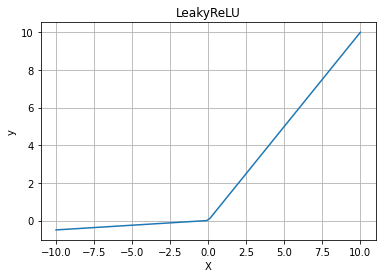

In [9]:
x = np.linspace(-10, 10, 100)
y = leakyrelu(x)

plt.plot(x, y)
plt.grid("on")
plt.xlabel("X")
plt.ylabel("y")
plt.title("LeakyReLU")

In [10]:
# define the ELU activation
def elu(x, a=1):
    return np.maximum(x, 0) + a * np.exp(np.minimum(x, 0) - 1)

Text(0.5, 1.0, 'ELU')

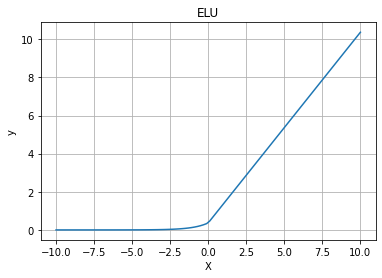

In [11]:
x = np.linspace(-10, 10, 100)
y = elu(x)

plt.plot(x, y)
plt.grid("on")
plt.xlabel("X")
plt.ylabel("y")
plt.title("ELU")

## 2. build a synthetic hypertension dataset

In [12]:
"""
two features: blood pressure, age

generate 10000 patients 
    - with blood pressure from 70 to 150
    - with age between 30 to 100

We set a very arbitrary rule: 
    if the blood pressure value + age >= 220, 
    then the patient has hypertension.
    
first 9000 patients as training
last 1000 as test
"""
blood = np.random.randint(70, 150, 10000)
age = np.random.randint(30, 100, 10000)
X = np.stack([blood, age]).T

# normalize X, try to omit the normalization and see the effect?
X = (X - X.mean(0)) / (X.std(0) + 1e-8)

hypertension = ((blood + age) >= 220).astype("int")

X_train, y_train = torch.FloatTensor(X[:9000]), \
        torch.FloatTensor(hypertension[:9000])
X_test, y_test = torch.FloatTensor(X[9000:]), \
        hypertension[9000:]

## 3. train a single neuron

### 3.1 initialize the model

In [13]:
import torch
import torch.nn as nn

# we implement a single neuron model
class HypertensionDetector(nn.Module):
    def __init__(self):
        super(HypertensionDetector, self).__init__()
        self.neuron = nn.Linear(2, 1)

    def forward(self, x):
        y = torch.sigmoid(self.neuron(x))
        return y

model = HypertensionDetector()

### 3.2 training and evaluation process

In [14]:
from sklearn.metrics import roc_auc_score

# define the loss function and optimizer
criterion = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1) # lr is the learning rate

for epoch in range(200):
    """ model training """
    model.train()
    y_hat = model(X_train)
    loss = criterion(y_hat.squeeze(1), y_train)
    
    optimizer.zero_grad()
    loss.backward() 
    optimizer.step() 
    
    """ model evaluation """
    model.eval()
    with torch.no_grad():
        y_pre = model(X_test).detach().numpy()
        print (f"{epoch}-th accuracy on test", \
               roc_auc_score(y_test, y_pre))

0-th accuracy on test 0.995570652173913
1-th accuracy on test 0.9958695652173913
2-th accuracy on test 0.9959103260869566
3-th accuracy on test 0.9960190217391305
4-th accuracy on test 0.9961413043478261
5-th accuracy on test 0.9962771739130435
6-th accuracy on test 0.9963451086956521
7-th accuracy on test 0.9965760869565218
8-th accuracy on test 0.996671195652174
9-th accuracy on test 0.9967663043478261
10-th accuracy on test 0.9967798913043479
11-th accuracy on test 0.9968342391304348
12-th accuracy on test 0.996929347826087
13-th accuracy on test 0.9970108695652175
14-th accuracy on test 0.9970923913043479
15-th accuracy on test 0.9970923913043478
16-th accuracy on test 0.9974320652173914
17-th accuracy on test 0.9974320652173914
18-th accuracy on test 0.9974320652173914
19-th accuracy on test 0.9974999999999999
20-th accuracy on test 0.9975135869565217
21-th accuracy on test 0.9975543478260869
22-th accuracy on test 0.9975815217391305
23-th accuracy on test 0.9976358695652174
24-th

## 4. train a DNN

In [15]:
class DNNHypertensionDetector(nn.Module):
    def __init__(self):
        super(DNNHypertensionDetector, self).__init__()
        # input dimension: 2
        # first layer neuron: 16
        # second layer neuron: 8
        # output dimension: 1
        
        self.f = nn.Linear(2, 16)
        self.g = nn.Linear(16, 8)
        self.h = nn.Linear(8, 1)

    def forward(self, x):
        neurons_l1 = torch.relu(self.f(x))
        neurons_l2 = torch.relu(self.g(neurons_l1))
        output = torch.sigmoid(self.h(neurons_l2))
        return output

model = DNNHypertensionDetector()

In [16]:
from sklearn.metrics import roc_auc_score

criterion = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1) # lr is the learning rate

for epoch in range(200):
    """ model training """
    model.train()
    y_hat = model(X_train)
    loss = criterion(y_hat.squeeze(1), y_train)
    
    optimizer.zero_grad()
    loss.backward() 
    optimizer.step() 
    
    """ model evaluation """
    model.eval()
    with torch.no_grad():
        y_pre = model(X_test).detach().numpy()
        print (f"{epoch}-th accuracy on test", \
               roc_auc_score(y_test, y_pre))

0-th accuracy on test 0.003505434782608698
1-th accuracy on test 0.003355978260869566
2-th accuracy on test 0.0033152173913043497
3-th accuracy on test 0.0031657608695652194
4-th accuracy on test 0.0030298913043478276
5-th accuracy on test 0.0030027173913043507
6-th accuracy on test 0.0029347826086956546
7-th accuracy on test 0.0028804347826086986
8-th accuracy on test 0.002975543478260871
9-th accuracy on test 0.0038451086956521707
10-th accuracy on test 0.0072554347826086964
11-th accuracy on test 0.014932065217391297
12-th accuracy on test 0.027350543478260866
13-th accuracy on test 0.04569293478260869
14-th accuracy on test 0.07137228260869566
15-th accuracy on test 0.09979619565217392
16-th accuracy on test 0.13144021739130435
17-th accuracy on test 0.1641711956521739
18-th accuracy on test 0.20251358695652172
19-th accuracy on test 0.24929347826086956
20-th accuracy on test 0.31001358695652176
21-th accuracy on test 0.40368206521739125
22-th accuracy on test 0.5272282608695652
23